# A simple UQ for the crossing date


In this notebook, we investigate a simple model to estimate the uncertainty in the baseline crossing date. At a broad level, such a model consists of performing $N_\text{sims}$ simulations, where for each simulation we independently compute the following two steps:

1. Simulate a path $R_i(t)$  of the dynamical behaviour of the *Raw Byte Power (RBP)* in time. Here, it is assumed that for a starting time $t_0\in\mathbb{R}_+$ common to all simulations, $R_i(t_0)=R_0$.  Notice that this path  is a random process(except for its initial point) that cannot be accurately forcasted. 
2. Estimate the crossing time of the $i$-th path $\tau_i$, given by 

$$\tau_i:=\min\left\{ t \in \mathbb{R}_+ \text{ such that } B(t)>R_i(t) \right\},$$

where $B(t)$ is the baseline function and it is assumed that $R_0>B(t_0)$.

Once these simulations are completed, one could then use the samples $\{\tau_i\}_{i=1}^{N_\text{sims}}$ to compute Monte Carlo estimators of the baseline crossing date. 

For the sake of simplicity, we will focus on a model for RBP of the form 

\begin{aligned}
R_i(t)&=R_0 e^{X_i(t)},\\
X_i(t)&=X_i(t-1)+\xi, \quad \xi\overset{\text{iid}}{\sim} \pi,\\
X_i(t_0)&=0,
\end{aligned}
where $\pi$ is the probability distribution of the difference of the logs in the RBP function, **which is assumed to be stationary.**


We emphasize that even though the previous model is quite simple and relies upon the strong assumption of having an underlying stationary distribution for the (log) increments in RBP, the same Monte Carlo procedure can be used with more complicated parametrization of the RBP dynamic.


We begin by importing the relevant  `python`  modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy import stats
from get_baseline import getBaseline
import matplotlib
import matplotlib.dates as mdates

font = {'size'   : 28,
        'family':'serif'}

matplotlib.rc('font', **font)

We now define functions to (a) sample from $\pi$ and generate the paths $R_i$ and (b) to obtain $\tau_i$.

In [2]:
class rbp_KDE_process:
    ''' 
        class to create a very simple distribution in order to simulate R. 
        The idea here is to estimate the distribution of $\pi$ via a KDE and then
        sampling from it. This will require historic RBP data'''
    
    def __init__(self,df):
        '''
        df: pd.DataFrame
        
        Historic data for RBP
        '''
        
        self.df=df
        self.KDE=stats.gaussian_kde(df['log_rbp'].diff().dropna())
        self.r0=df['total_raw_bytes_power'].iloc[-1]
        
    def sample(self,Ndays:int):
        '''
        This function creates an RBP path of length Ndays.
    
        Ndays: how long to forecast
        '''
        ss=self.KDE.resample(Ndays)[0]
        se=self.r0*np.exp(np.cumsum(ss))
        today=datetime.datetime.today()
        df=pd.DataFrame({
            'time':[today + datetime.timedelta(days=d) for d in range(Ndays)],
            'rbp':se
            })
        df=df.resample('D', on='time').last()
        return df
    

def find_crossing(bl,R_i,today):
    '''
    this function finds the baseline crossing time, tau.
    here:
        bl:pd.DataFrame, baseline function
        R_i:pd.DataFrame, a path R_i
        today: datetime object for today's date    
    '''
    
    bl=bl[bl.index>=today]
    R_i=R_i[bl['total_power']>R_i['rbp']]
    return R_i['time'].iloc[0]

We assume that $\pi$ is the behaviour of the historical RBP after an arbitrary date, `CUTOFF`. This is done since, clearly, RBP has changed overtime, and it has been decreasing in the last couple of months (Sept. 2022). 


We now read some data, define some parameters, and instantiate the class to simulate RBP. 

In [3]:
today=str(datetime.date.today())
df=pd.read_json('powers.json').dropna() #historical RBP data
df['log_rbp']=df['total_raw_bytes_power'].apply(lambda x: np.log(x))
TO_EBI=2**60
CUTOFF='2022-09-01'   
Ndays=365*2
Nsims=2000
baseline=getBaseline(Ndays)
kde=rbp_KDE_process(df[df.index>CUTOFF])

We are now ready to perform our Monte Carlo simulation.

In [4]:
samps=[]
tau=[]
for i in range(Nsims):
    ss=kde.sample(Ndays)
    tau.append(find_crossing(baseline, ss,today))
    samps.append(ss)

Lastly, we plot our results

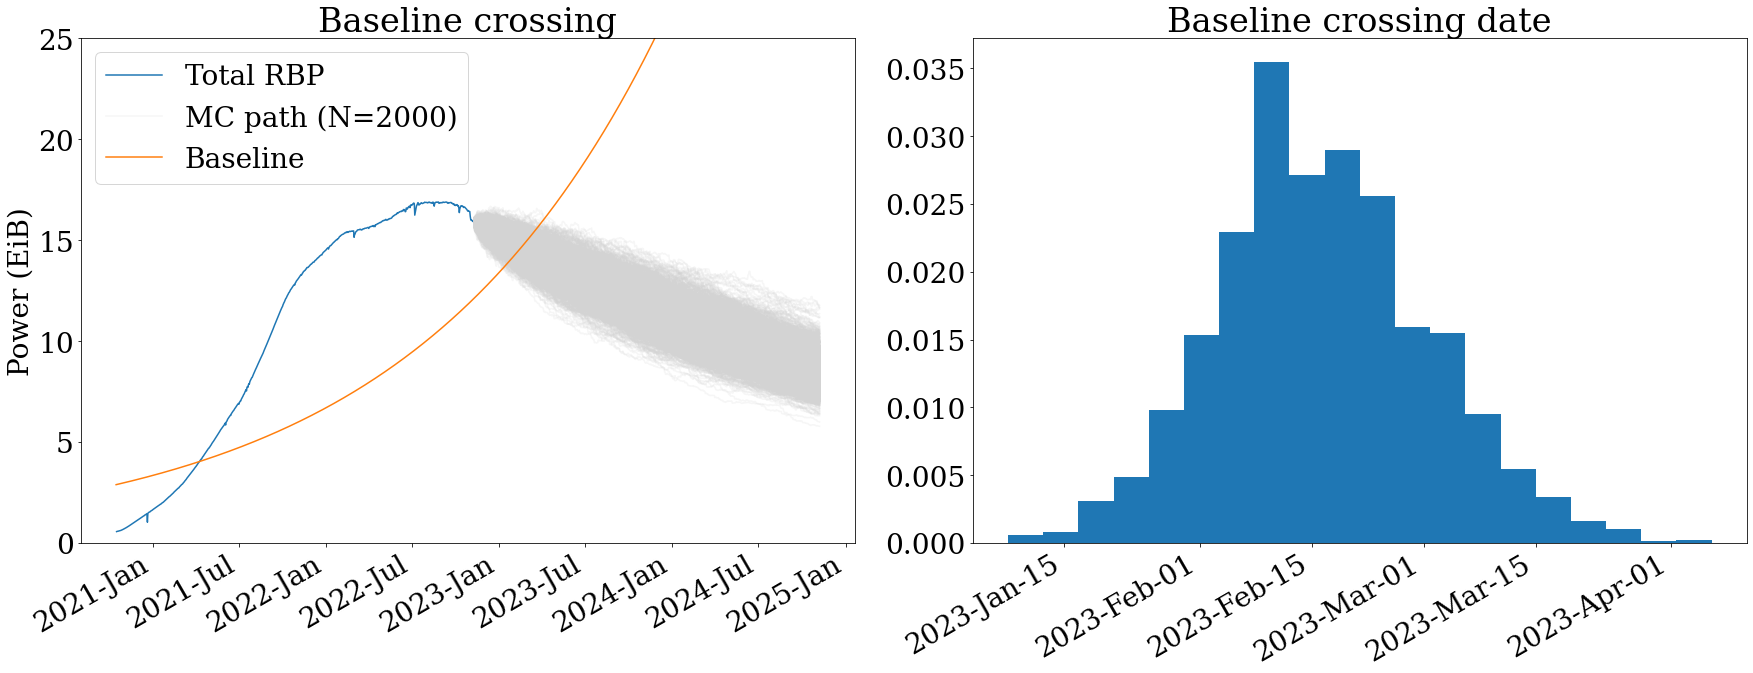

In [5]:
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].plot(df['total_raw_bytes_power']/TO_EBI,label='Total RBP')
for i in range(Nsims):
    ss=samps[i]     
    if i==0:
        ax[0].plot(ss['rbp']/TO_EBI,color='lightGray',alpha=0.2,label='MC path (N={})'.format(Nsims))
    else:
        ax[0].plot(ss['rbp']/TO_EBI,color='lightGray',alpha=0.2)
ax[0].plot(baseline/TO_EBI,label='Baseline')
ax[0].set_ylim([0,2.5e1])
ax[0].legend()
ax[0].set_title('Baseline crossing')
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
ax[0].xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
fig.autofmt_xdate()

#ax[0].set_xticks(ticks=rotation=90)
ax[0].set_ylabel('Power (EiB)')

plt.hist(tau,bins=20,density=True)
dtFmt = mdates.DateFormatter('%Y-%b-%d') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.title('Baseline crossing date')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [7]:
print('first baseline crossing:')
baseline[:365][baseline[:365].values.flatten() > (df['total_raw_bytes_power']).values[:365]].index[-1]

first baseline crossing:


Timestamp('2021-04-07 00:00:00')

In [9]:
date=pd.DataFrame({'time':tau})
mean=date.mean(numeric_only=False)['time']
sd=date.std()['time']
print('expected crossing date {} +- {}'.format(mean,sd))

expected crossing date 2023-02-16 08:55:24.662481152 +- 13 days 03:07:10.061413195
